# DATA SOURCE

In [1]:
######################################################## LIBRARIES ########################################################

import pandas as pd

import numpy as np

from sklearn.preprocessing import MinMaxScaler

import os


######################################################## CONSTANTS ########################################################
import CONSTANTS as c


PREPROCESSED_DATA_PATH = c.PREPROCESSED_DATA_PATH
FEATURE_ENGINEERED_DATA_PATH = c.FEATURE_ENGINEERED_DATA_PATH

NR_OF_BOUNDARIES = 128
BIN_BOUNDARIES = np.linspace(1.170, 1.185, NR_OF_BOUNDARIES) 
SIZE_OF_CHUNK = 30
ATTENTION_KEY_DIMS = 64
ATTENTION_NR_OF_HEADS = 6
ENCODER_DENSE_DIMS = 32
DROPOUT_RATE = 0
NR_OF_ENCODER_BLOCKS = 3


######################################################## DATA SOURCE ########################################################
i = 0
for oFile in os.walk(PREPROCESSED_DATA_PATH):
    sFolderPath = oFile[0]
    
    if sFolderPath != PREPROCESSED_DATA_PATH:
        sSubFolder = sFolderPath.split('\\')[-1]
        
        sFolderToWrite = r'{}\{}'.format(FEATURE_ENGINEERED_DATA_PATH, sSubFolder)
        
        if os.path.exists(sFolderToWrite) == False:
            os.makedirs(sFolderToWrite)
        
        if all(elem in os.listdir(sFolderToWrite)  for elem in  ['X_ORIGINAL.npy', 'X_ORIGINAL.npy', 'X_ORIGINAL.npy']) == True:
            continue

            
        X_ORIGINAL = np.load(r'{}\X_ORIGINAL.npy'.format(sFolderPath))
        X_TIME_ORIGINAL = np.load(r'{}\X_TIME_ORIGINAL.npy'.format(sFolderPath))
        Y_ORIGINAL = np.load(r'{}\Y_ORIGINAL.npy'.format(sFolderPath))
        
        
        if i ==0:
            X = X_ORIGINAL
            Y = Y_ORIGINAL
            X_TIME = X_TIME_ORIGINAL
        else:
            X = np.concatenate([X, X_ORIGINAL])
            X_TIME = np.concatenate([X_TIME, X_TIME_ORIGINAL])
            Y = np.concatenate([Y, Y_ORIGINAL])            
        
        i = i +1
        
        if i == 3:
            break

            


X = X[:,:,:,0]
Y = Y[:,:,:,0]


# revert back to prices from change_rates
sExchangeRate = 'EURUSD'
df = pd.read_csv(r'Data\{}_M1_202010010001_202210312359.csv'.format(sExchangeRate), delimiter = '\t')
df.loc[:, 'PRICE_TIME_STAMP'] = pd.to_datetime(df['<DATE>'] + df['<TIME>'], format='%Y.%m.%d%H:%M:%S')
df.drop(['<DATE>', '<TIME>'], axis = 1, inplace = True)
df.loc[:, 'EXCHANGE_RATE'] = sExchangeRate


dfTime = pd.DataFrame(
    data = X_TIME,
    columns = ['MINUTE', 'HOUR', 'DAY_OF_WEEK', 'DAY_OF_MONTH', 'MONTH', 'YEAR'])

dfTime['TIME_STAMP'] = pd.to_datetime(
    dfTime['YEAR'].astype(str) \
    + '-' + dfTime['MONTH'].astype(str) \
    + '-' + dfTime['DAY_OF_MONTH'].astype(str) \
    + ' ' + dfTime['HOUR'].astype(str) \
    + ':' + dfTime['MINUTE'].astype(str) , 
    format='%Y-%m-%d %H:%M:%S')

dfTime = dfTime[['TIME_STAMP']]


aClosePrices = dfTime.merge(
    right = df[['PRICE_TIME_STAMP','<CLOSE>']], 
    left_on = 'TIME_STAMP',
    right_on = 'PRICE_TIME_STAMP',
    how = 'inner'
)[['<CLOSE>']].values
aClosePrices = np.expand_dims(aClosePrices, 2)


X = (X * aClosePrices) + aClosePrices
Y = (Y * aClosePrices) + aClosePrices

X = X.reshape(X.shape[0] , -1)
Y = Y.reshape(Y.shape[0] , -1)


# XTIME consists of minute, hour, day of week, day of month, month, year
# exclude month and year.
X_TIME = X_TIME[:, :4]

X_SOURCE = X.copy()
Y_SOURCE = Y.copy()
X_TIME_SOURCE = X_TIME.copy()

# EXPLORATORY DATA ANALYSIS

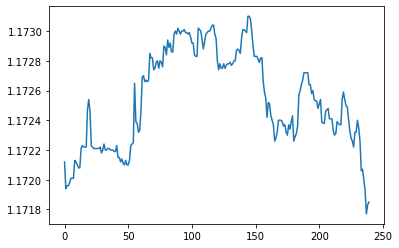

In [2]:
######################################################## EXPLORATORY DATA ANALYSIS ########################################################
import matplotlib.pyplot as plt
iIndex = 1

plt.plot(X[iIndex])
plt.show()

(array([ 915., 1869., 2136., 5833., 8347., 7491., 9865., 4809., 1847.,
         470.]),
 array([1.16085 , 1.163957, 1.167064, 1.170171, 1.173278, 1.176385,
        1.179492, 1.182599, 1.185706, 1.188813, 1.19192 ]),
 <BarContainer object of 10 artists>)

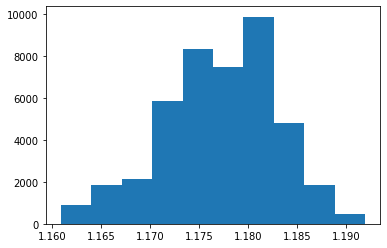

In [3]:
plt.hist(Y[:, 0])

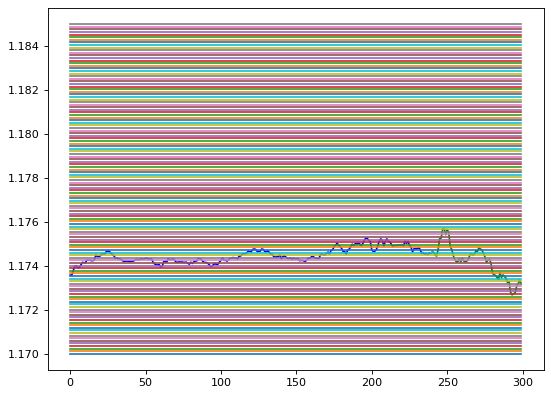

In [4]:
iIndex = 350
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.arange(X.shape[1]), X[iIndex], color=  'blue')
plt.plot(np.arange(X.shape[1], X.shape[1] + Y.shape[1]), Y[iIndex], color=  'green')

for i in BIN_BOUNDARIES:
    plt.plot(np.ones(X.shape[1] + Y.shape[1]) * i)

# MODEL

In [22]:
######################################################## MODEL ########################################################
import tensorflow as tf

class DisERT(tf.Module):
    def __init__(
        self,
        p_bin_boundaries,
        p_size_of_chunk
    ):
        super(DisERT, self).__init__()
        
        self.size_of_chunk = p_size_of_chunk
        
        aLayers = [
            tf.keras.layers.Reshape((-1, p_size_of_chunk)),
            tf.keras.layers.TimeDistributed(
                tf.keras.layers.Discretization(
                    bin_boundaries = p_bin_boundaries,
                    output_mode = 'count'
                )
            ),
            tf.keras.layers.Rescaling(scale = 1/p_size_of_chunk) # could be applied softmax as well.
        ]
        
        self.InputBinDistributionByChunks = tf.keras.Sequential(aLayers)       


    # x should be in format (nr_of_samples, time_step, nr_of_features)
    def mask(self, x, p_masking_rate = 0.20, p_mask_value = 0.555):
        # mask only time steps...
        mask = np.random.rand(x.shape[0],x.shape[1]) < p_masking_rate

        # Set targets to -1 by default, it means ignore
        y_mlm =  -1 * np.ones(x.shape)

        # Set labels for masked tokens
        y_mlm[mask] = x[mask]
        
        # set masked mlm_input
        x_mlm = np.copy(x)
        x_mlm[mask] =  0.555 * np.ones(x.shape[2])
        
        return x_mlm, y_mlm
    
    
    # x: represents the chunked values with the shape (nr_of_samples, time_steps (chunks), feature_size )
    # y: represents the class for next sentence prediction with the shape (nr_of_sampples, 1)
    def inject_noise(self, x, y):
        # we will roll the bins
        x_backward = x[:, :self.backward_nr_of_chunks,:]
        x_forward = x[:, self.backward_nr_of_chunks:,:]
        
        x_forward_noise = tf.random.shuffle(x_forward)
        
        # if still same forecast chunks comes after shuffling (even thogh small percentage), we are going to set nsp class to 1.
        y_forward_noise = tf.cast(tf.math.reduce_all(x_forward_noise == x_forward, axis = (1, 2)), dtype = tf.dtypes.float64)
        
        y_noise = tf.expand_dims(y_forward_noise,  axis = 1)
        
        x_noise = tf.keras.layers.concatenate([x_backward,x_forward_noise ], axis = 1)
        
        y = tf.keras.layers.concatenate([y, y_noise], axis = 0)
        x = tf.keras.layers.concatenate([x, x_noise], axis = 0)
                
        return x, y
    
    
    def shuffle(self, x_mlm, y_mlm, x_nsp, y_nsp):
        indices = tf.range(start=0, limit=tf.shape(x_mlm)[0], dtype=tf.int32)
        
        idx = tf.random.shuffle(indices)
        
        x_mlm = tf.gather(x_mlm, idx)
        y_mlm = tf.gather(y_mlm, idx)
        x_nsp = tf.gather(x_nsp, idx)
        y_nsp = tf.gather(y_nsp, idx)
        
        
        return x_mlm, y_mlm, x_nsp, y_nsp
        
    # x: represents the lagged backcast values with the shape (nr_of_samples, time_steps) 
    # y: represents the lagged forecast values with the shape (nr_of_samples, time_steps) 
    def preprocess(self, x, y):
        
        self.backward_time_steps = x.shape[1]
        self.forward_time_steps = y.shape[1]
        
        self.backward_nr_of_chunks = int(self.backward_time_steps/self.size_of_chunk)
        self.forward_nr_of_chunks = int(self.forward_time_steps/self.size_of_chunk)
        
        # for masked language model, both x and y are concatted.
        x_mlm = tf.keras.layers.concatenate(
            [x, y], axis = 1
        )
        
        x_mlm = self.InputBinDistributionByChunks(x_mlm)
        
        y_nsp = tf.ones([x_mlm.shape[0], 1])
        
        x_mlm, y_nsp = self.inject_noise(x_mlm, y_nsp)
        
        x_mlm, y_mlm = self.mask(x_mlm)
        
        x_mlm = tf.convert_to_tensor(x_mlm)
        y_mlm = tf.convert_to_tensor(y_mlm)

        x_nsp = tf.ones([x_mlm.shape[0], 1, x_mlm.shape[2]]) * 0.5 # 0.5 acts as CLS
        
        x_mlm, y_mlm, x_nsp, y_nsp = self.shuffle(x_mlm, y_mlm, x_nsp, y_nsp)
        
            
        return x_mlm, y_mlm, x_nsp, y_nsp


X = X_SOURCE.copy()
Y =  Y_SOURCE.copy()

# Limits of BIN_BOUNDARIES should be calculated dynamically. Otherwise, it creates too sparse input dataset which may not be good for learning.
# Idea #1: to use daily minimum and maximum...
# Idea #2: Keep it sparse however, apply FFT to get differences...
# Idea #3: We can have several more BIN_BOUNDARIES variables...
# I think, Idea #1 is more secure... However, we need to build higher scale logic...
# Higher scale can be part of any X_TIME feature.
# However, we must keep, NR_OF_BOUNDARIES constant
oDisERT = DisERT(
        p_bin_boundaries = BIN_BOUNDARIES,
        p_size_of_chunk = SIZE_OF_CHUNK
)
X_MLM, Y_MLM, X_NSP, Y_NSP = oDisERT.preprocess(X[:1000], Y[:1000])

In [61]:
class PositionEncoder(tf.Module):
    def __init__(self, input_dim, output_dim ):
        super(PositionEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.pos_enc = get_pos_encoding_matrix(input_dim, output_dim)
        
        
    def __call__(self, x):
        position_embeddings = tf.keras.layers.Embedding(
            input_dim= self.input_dim,
            output_dim=self.output_dim,
            weights=[self.pos_enc],
            name="position_embedding",
        )(x)
        
        return position_embeddings

        
    def get_pos_encoding_matrix(max_len,d_emb ):
        pos_enc = np.array(
            [
                [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
                if pos != 0
                else np.zeros(d_emb)
                for pos in range(max_len)
            ]
        )
        pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
        pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
        return pos_enc



class TransformerEncoder(tf.Module):
    def __init__(self, key_dim, num_heads, ff_dim, dropout):
        super(TransformerEncoder, self).__init__()
        self.key_dim = key_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout = dropout
        
        
    def __call__(self, x):
        # Normalization and Attention
        y = tf.keras.layers.LayerNormalization(epsilon =1e-6)(x)
        
        y = tf.keras.layers.MultiHeadAttention(
            key_dim=self.key_dim,
            num_heads = self.num_heads,
            dropout = self.dropout
        )(y,y) # self attention
        
        
        y = tf.keras.layers.Dropout(self.dropout)(y)
        res = y + x
        
        # Feed Forward Part
        y = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(res)
        y = tf.keras.layers.Conv1D(filters = self.ff_dim, kernel_size=  1, activation = 'relu')(y)
        y = tf.keras.layers.Dropout(self.dropout)(y)
        y = tf.keras.layers.Conv1D(filters=x.shape[-1], kernel_size = 1)(y)
        
        return y + res
        

mlm_input = tf.keras.layers.Input((X_MLM.shape[1], X_MLM.shape[2]), name = 'mlm_input')
nsp_input = tf.keras.layers.Input((X_NSP.shape[1], X_NSP.shape[2]), name = 'nsp_input')

x = tf.keras.layers.Concatenate(axis = 1)([mlm_input, nsp_input])


x_positions = (tf.range(start=0, limit=x.shape[1], delta=1))
x_position_embeddings = PositionEncoder(
    input_dim = x.shape[1] , 
    output_dim = x.shape[2]
)(x_positions)
x = tf.add(x, x_position_embeddings)

for i in range(NR_OF_ENCODER_BLOCKS):
    x = TransformerEncoder(ATTENTION_KEY_DIMS, ATTENTION_NR_OF_HEADS, ENCODER_DENSE_DIMS, DROPOUT_RATE)(x)

mlm_output = tf.keras.layers.Dense(X_MLM.shape[2], activation = 'softmax', name = 'mlm_classifier')(x)

x = tf.keras.layers.Flatten()(x)
nsp_output = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'nsp_classifier')(x)

DisERT_model = tf.keras.Model(inputs = [mlm_input, nsp_input], outputs= [mlm_output, nsp_output])

def mlm_custom_loss(y_true, y_pred):
    # y_true for mlm is without cls token. So we should ignore the cls_token time step of y_pred.
    # since cls token is the latest latest token of prediction, we ignore that token.
    y_pred_without_special_tokens = y_pred[:, :-1, :]
    non_masks = tf.cast(tf.not_equal(y_true, -1), tf.dtypes.float64)
    
    y_pred_non_mask = tf.cast(y_pred_without_special_tokens, tf.dtypes.float64)
    y_true_non_mask = tf.cast(y_true, tf.dtypes.float64)
    
    oBinCE = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    
    loss = oBinCE(y_true_non_mask*non_masks , y_pred_non_mask * non_masks)
    loss = tf.reduce_mean(loss)
    
    return loss

def nsp__custom_loss(y_true, y_pred):
    oBinCE = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    
    loss = oBinCE(y_true , y_pred)
    loss = tf.reduce_mean(loss)
    
    return  loss
        

DisERT_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss = [mlm_custom_loss, nsp__custom_loss]
)

# print(DisERT_model.summary())
tf.keras.utils.plot_model(DisERT_model, show_shapes=True)

DisERT_model.fit(
    x = [X_MLM, X_NSP], 
    y = [Y_MLM, Y_NSP], 
    batch_size= 128,
    epochs=50,
    verbose=1
)

Epoch 1/50
16/16 [==============================] - 13s 134ms/step - loss: 1.2735 - mlm_classifier_loss: 0.0111 - nsp_classifier_loss: 1.2624
Epoch 2/50
16/16 [==============================] - 2s 122ms/step - loss: 0.7584 - mlm_classifier_loss: 0.0083 - nsp_classifier_loss: 0.7501
Epoch 3/50
16/16 [==============================] - 2s 123ms/step - loss: 0.7159 - mlm_classifier_loss: 0.0075 - nsp_classifier_loss: 0.7084
Epoch 4/50
16/16 [==============================] - 2s 123ms/step - loss: 0.7087 - mlm_classifier_loss: 0.0073 - nsp_classifier_loss: 0.7014
Epoch 5/50
16/16 [==============================] - 2s 123ms/step - loss: 0.7050 - mlm_classifier_loss: 0.0072 - nsp_classifier_loss: 0.6978
Epoch 6/50
16/16 [==============================] - 2s 123ms/step - loss: 0.7089 - mlm_classifier_loss: 0.0072 - nsp_classifier_loss: 0.7017
Epoch 7/50
16/16 [==============================] - 2s 123ms/step - loss: 0.7047 - mlm_classifier_loss: 0.0072 - nsp_classifier_loss: 0.6976
Epoch 8/50
1

63/63 [==============================] - 1s 17ms/step


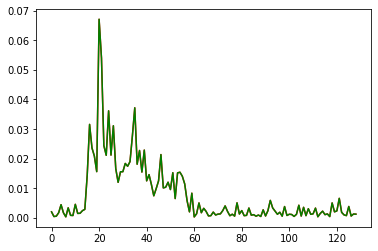

In [63]:
y_pred_mlm, y_pred_nsp = DisERT_model.predict([X_MLM, X_NSP])
y_true_mlm = Y_MLM
y_true_nsp = Y_NSP

plt.plot(y_pred_mlm[900][2], color = 'red')
plt.plot(y_pred_mlm[900][2], color = 'green')

In [72]:
oBinCE = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

true = tf.convert_to_tensor([1, 1, 0, 0,0 ,0])
pred =tf.convert_to_tensor([0.50, 0.60, 0, 0,0 ,0])
oBinCE(true, pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.20066206>